# simulation experiment
The composition schema was developed for integrative simulations, but can also be used for workflows such as simulation experiments. This experimental notebook demonstrates simulation experiments as composites, going from the declarative JSON format to executable python script.  

Example scripts were provided here: https://docs.google.com/document/d/1jZkaNhM_cOqMWtd4sJZ9b0VGXPTLsDKsRNI5Yvu4nOA/edit

## imports

In [28]:
from bigraph_viz import plot_bigraph, plot_flow, pf
from bigraph_viz.dict_utils import schema_keys
from sed2.core import register, ports, annotate, Composite, ProcessRegistry, serialize_instance
from sed2.processes import sed_process_registry
import numpy as np

schema_keys.extend(['_type', 'config'])
sbml_model_path = 'sed2/susceptible_zombie.xml'
sbml_model_description_path = 'sed2/susceptible_zombie.csv'

## print the sed process registry
These are the sed processes required to generate all of the examples. The processes used in this notebook are imported from a local library `sed2` and are added to the global namespace for easy calls. Different instances may use remote processes accessed as a service, or local Docker containers, or combinations of these.

In [29]:
# add sed processes to global namespace
sed_process_registry.activate_all(globals())
print(pf(sed_process_registry.registry))

{ 'control:range_iterator': { 'address': <class 'sed2.core.RangeIterator'>,
                              'annotation': 'more info here?',
                              'class': 'composite',
                              'ports': {'results': 'list', 'trials': 'int'}},
  'control:range_iterator:model': { 'address': <class 'sed2.core.RangeIteratorModel'>,
                                    'annotation': 'more info here?',
                                    'class': 'composite',
                                    'ports': { 'model_instance': 'Model',
                                               'results': 'list',
                                               'trials': 'int'}},
  'data_description': { 'address': <function data_description at 0x28dfde820>,
                        'annotation': 'sed:data_description',
                        'class': 'function',
                        'ports': { 'data': 'pd.DataFrame',
                                   'data_file': 'str',
           

## example 1
Run a simulation from time start to time end with a given number of points/steps.  The run will return a 2D array of results.

This is the script we aim to reproduce with SED-2:
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
sim1 = uniform_time_course(model_instance, 0, 10, 50, selection_list=['time', 'S', 'Z'])
curves = {
    'Susceptible': {'x': 'time', 'y': 'S'},
    'Zombie': {'x': 'time', 'y': 'Z'}
}
plot2d(results=sim1, curves=curves, name='Figure3')
```

### SED-2 document

This declarative document describes the simulation experiment, with values and processes all declared in a simple format which can be serialized to JSON and shared.

In [30]:
instance1 = {
    'time_start': 0,
    'time_end': 10,
    'num_points': 50,
    'selection_list': ['time', 'S', 'Z'],
    'model_path': sbml_model_path,
    'curves': {
        'Susceptible': {'x': 'time', 'y': 'S'},
        'Zombie': {'x': 'time', 'y': 'Z'}
    },
    'figure1name': '"Figure1"',
    'sbml_model_from_path': {
        '_type': 'model_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'plot2d': {
        '_type': 'plot2D',
        'wires': {
            'results': 'results',
            'curves': 'curves',
            'name': 'figure1name',
            'figure': 'figure'
        },
        '_depends_on': ['uniform_time_course'],
    },
    'uniform_time_course': {
        '_type': 'uniform_time_course',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path'],
    },
}

### make a composite process and run it

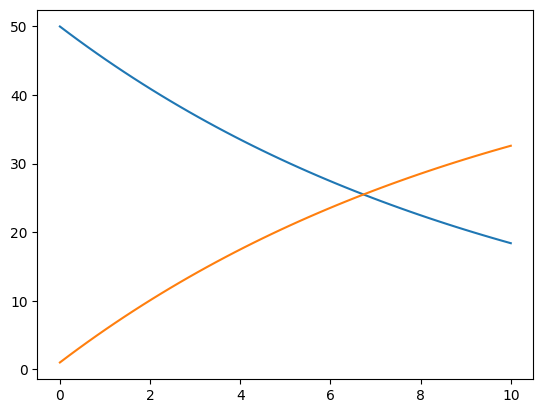

In [31]:
sim_experiment = Composite(
    config=instance1,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

### plot function map

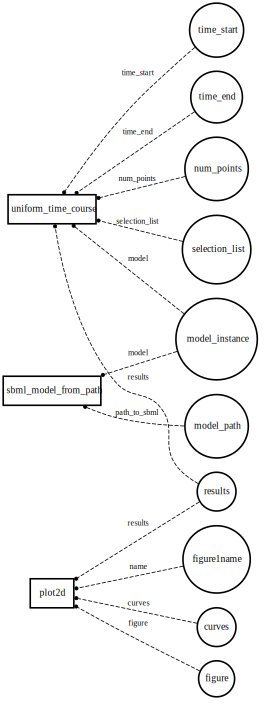

In [32]:
remove_nodes = [('curves', 'Susceptible'),('curves', 'Zombie'),]
plot_bigraph(instance1, remove_nodes=remove_nodes, rankdir='RL')

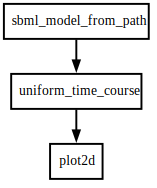

In [33]:
# Plot the flow diagram
plot_flow(instance1)

## example 2
Run a single steady-state simulation, The run returns a 1D array containing the steady state values.

The script we aim to generate:
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
ss1 = steady_state_values(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')
```

In [34]:
sed_process_registry.access('steady_state')

{'annotation': 'sed:steady_state_values',
 'ports': {'model': 'Model', 'selection_list': 'list', 'results': 'dict'},
 'address': <function sed2.processes.steady_state_values(model, selection_list)>,
 'class': 'function'}

In [35]:
# SED documnt serialized
instance2 = {
    'model_path': sbml_model_path,
    'UTC': '"UTC"',
    'selection_list': ['S', 'Z'],
    'sbml_model_from_path': {
        '_type': 'model_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'steady_state_values': {
        '_type': 'steady_state',
        'wires': {
            'model': 'model_instance',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state_values']
    }
}

In [36]:
sim_experiment = Composite(
    config=instance2,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

"UTC"
S: 1.0587911840678754e-22
Z: 51.0


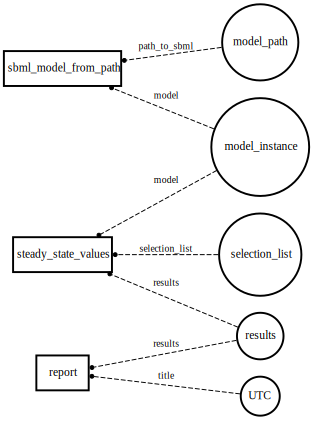

In [37]:
plot_bigraph(instance2, rankdir='RL')

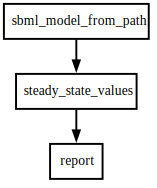

In [38]:
# Plot flow diagram
plot_flow(instance2)

## example 3
Set parameters and/or initial conditions and run time course or steady state evaluation.

```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
set_model(model_instance, 'Z', 0.0)
ss1 = steady_state_values(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')
```

In [39]:
instance3 = {
    'model_path': sbml_model_path,
    'sbml_model_from_path': {
        '_type': 'model_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'element_id': 'Z',
    'element_value': 0.0,
    'model_set_value': {
        '_type': 'set_model',
        'wires': {
            'model_instance': 'model_instance',
            'element_id': 'element_id',
            'value': 'element_value'
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'selection_list': ['S', 'Z'],
    'steady_state_values': {
        '_type': 'steady_state',
        'wires': {
            'model': 'model_instance',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['model_set_value']
    },
    'report': {
        '_type': 'report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state_values']
    }
}

In [40]:
sim_experiment = Composite(
    config=instance3,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

S: 1.0587911840678754e-22
Z: 51.0


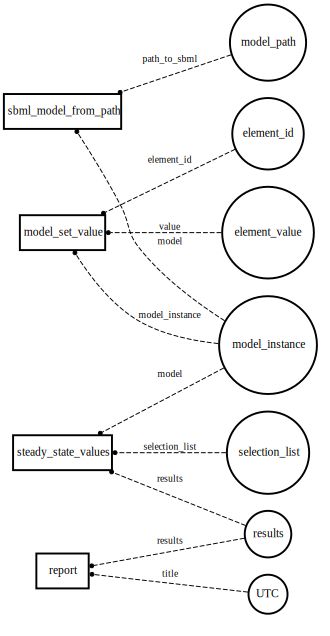

In [41]:
plot_bigraph(instance3, rankdir='RL')

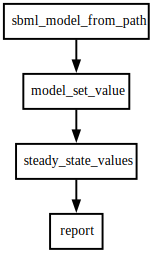

In [42]:
# Plot flow diagram
plot_flow(instance3)

## example 4
Repeat simulations any number of times and with any degree of nesting.  Any changes may be applied to parameters, initial conditions etc within the repeated simulations.  The results of the simulation will be collected into arrays.
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
config = {
    'Z': list(range(1, 11))
}
results = repeated_simulation(model_instance, config)
report(results, title='Different starting Z values')
```

In [43]:
instance4 = {
    'model_path': sbml_model_path,
    'sbml_model_from_path': {
        '_type': 'model_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'repeated_sim_config':{'Z': list(range(1, 11))},
    'repeated_simulation': {
        '_type': 'repeated_simulation',
        'wires': {
            'model_instance': 'model_instance',
            'config': 'repeated_sim_config',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['repeated_simulation']
    }
}

In [44]:
sim_experiment = Composite(
    config=instance4,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94003035 30.32651341 23.61828935 18.39390318]
Z: [ 1.         12.05996965 20.67348659 27.38171065 32.60609682]


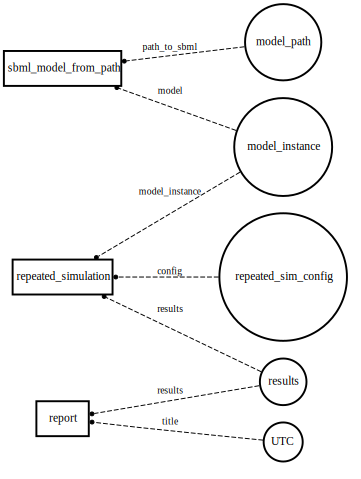

In [45]:
remove_nodes = [('repeated_sim_config', 'Z')]
plot_bigraph(instance4, remove_nodes=remove_nodes, rankdir='RL')

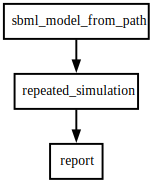

In [46]:
# Plot flow diagram
plot_flow(instance4)

## example 5
Carry out an n-D parameter scan and return the results in an array.
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
SZ_data = data_description('susceptible_zombie.csv', 'CSV')
config = {
    'S': np.arange(0.0, 0.010, step=0.002),
    'Z': np.arange(0.0, 0.010, step=0.002)
}
results = n_dimensional_scan(
    input_dict=config, 
    model=model_instance,
    data_description=SZ_data,
    time_start=0, 
    time_end=10, 
    num_points=5
)
report(results, title='Parameter scan')
```

In [47]:
instance5 = {
    'model_path': sbml_model_path,
    'model_instance': None,
    'UTC': '"UTC"',

    # load the model
    'sbml_model_from_path': {
        '_type': 'model_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },

    # set up trials
    's_trials': 5,

    # a composite process
    'n_dimensional_scan': {
        '_type': 'control:range_iterator:model',
        'wires': {
            'trials': 's_trials',
            'model_instance': 'model_instance',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path'],

        # state within for_loop
        'time_start': 0,
        'time_end': 10,
        'num_points': 5,
        
        # TODO -- do a set_model in here

        # process within for_loop
        'uniform_time_course': {
            '_type': 'uniform_time_course',
            'wires': {
                'model': 'model_instance',  #  ['..', 'model_instance'],  # TODO -- get these to connect
                'time_start': 'time_start',
                'time_end': 'time_end',
                'num_points': 'num_points',
                'selection_list': 'selection_list',
                'results': 'results',
            },
            '_depends_on': ['..', 'sbml_model_from_path'],  # TODO -- add ".."
        },
    },
    'results': None,  # this should be optional

    # report results
    'report': {
        '_type': 'report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['n_dimensional_scan']
    }
}

In [48]:
sim_experiment = Composite(
    config=instance5,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

"UTC"
time: [ 0.   2.5  5.   7.5 10. ]
[S]: [0.91577021 0.71320003 0.55544314 0.43257921 0.33689202]
[Z]: [50.08422979 50.28679997 50.44455686 50.56742079 50.66310798]


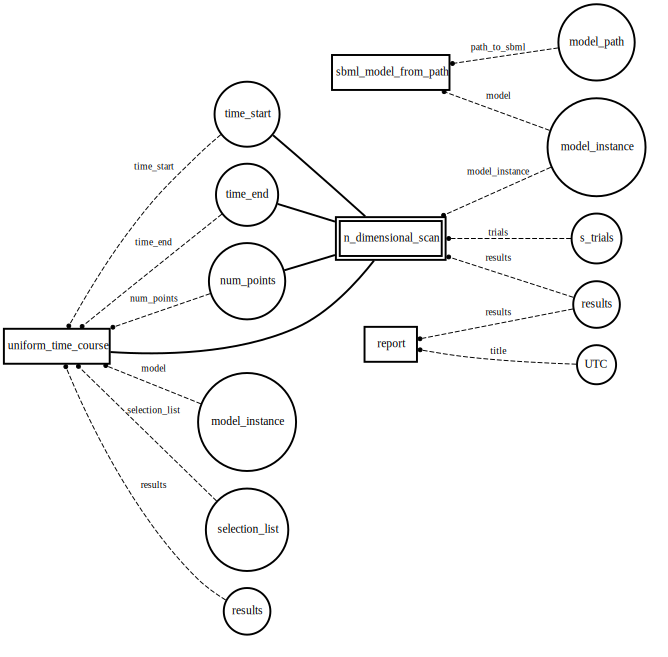

In [49]:
# remove_nodes = []
plot_bigraph(instance5, rankdir='RL')

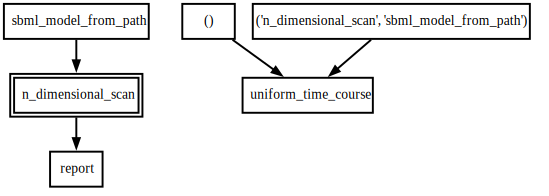

In [50]:
# Plot flow diagram
plot_flow(instance5)

## math process

In [51]:
math_example = {
    'equation': 'x**2 + a*x + b',
    'vars': {'x': 0},
    'params': {'a': 1, 'b': -6},
    'math_process': {
        '_type': 'math:solve_equation',
        'wires': {
            'equation_str': 'equation',
            'initial_vars': 'vars',
            'parameters': 'params',
            'results': 'results',
        },
    },
    'wires': {
        'results': 'results',
    }
}

math_example_experiment = Composite(
    config=math_example,
    process_registry=sed_process_registry)

results = math_example_experiment.update()

print(pf(results))

{'results': {'x': 2}}
